Setup

In [1]:
import pclpy
import numpy as np
import Libraries.Utils as Utils
import Libraries.Tree_Tool as Tree_Tool
import pandas as pd
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

In [18]:
verticalityThresh = 0.04
NonNANcurvatureThresh = 0.06

lowstems_Height = 5
cutstems_Height = 5

searchRadius=0.1
tol=0.1
minc=40
maxc=6000000
max_angle=0.4
    
    
EvaluationMetrics = {}

EvaluationMetrics['Completeness'] = []
EvaluationMetrics['Correctness'] = []
EvaluationMetrics['Mean_AoD'] = []
EvaluationMetrics['Diameter_RMSE'] = []
EvaluationMetrics['Diameter_RMSE_E'] = []
EvaluationMetrics['Diameter_RMSE_C'] = []
EvaluationMetrics['Diameter_bias'] = []
EvaluationMetrics['Location_RMSE'] = []
EvaluationMetrics['Location_bias'] = []

EvaluationMetrics['Relative_Diameter_RMSE'] = []
EvaluationMetrics['Relative_Diameter_bias'] = []
EvaluationMetrics['Relative_Location_RMSE'] = []
EvaluationMetrics['Relative_Location_bias'] = []

EvaluationMetrics['n_ref'] = []
EvaluationMetrics['n_match'] = []
EvaluationMetrics['n_extr'] = []
EvaluationMetrics['location_y'] = []
EvaluationMetrics['diameter_y'] = []

In [19]:
Mysegmentor = Tree_Tool.TreeTool()

for number in range(1,7):
    print('load point cloud ', number)
    PointCloud = pclpy.pcl.PointCloud.PointXYZ()
    pclpy.pcl.io.loadPCDFile('D:/Documentos/ParaAutonomia/Python/Proyecto/Data/NistClouds/downsampledlesscloudEURO' + str(number) + '.pcd',PointCloud)

    Mysegmentor.set_point_cloud(PointCloud)
    Mysegmentor.set_Ksearch(0.08)
    Mysegmentor.Full_Process(verticalityThresh=verticalityThresh,
        NonNANcurvatureThresh=NonNANcurvatureThresh,
        tol=tol,
        minc=minc,
        maxc=maxc,
        max_angle=max_angle,
        lowstems_Height=lowstems_Height,
        cutstems_Height=cutstems_Height,
        searchRadius=searchRadius)

    #####################################################
    print('Get ground truth')
    treedata = pd.read_csv('D:/Documentos/ParaAutonomia/Python/Proyecto/Data/EuroSDR_DataRelease/EuroSDR_DataRelease/TLS_Benchmarking_Plot_' + str(number) + '_LHD.txt',sep = '\t',names = ['x','y','height','DBH'])
    Xcor,Ycor,diam = treedata.iloc[0,[0,1,3]]
    surtreesL1 = [Utils.makecylinder(model=[Xcor, Ycor, 0,0,0,1,diam/2],length=10,dense=20)]
    Zcor = 0
    TreeDict = [np.array([Xcor,Ycor,diam])]
    for i,rows in treedata.iloc[1:].iterrows():
        Xcor,Ycor,diam = rows.iloc[[0,1,3]]
        if not np.any(np.isnan([Xcor,Ycor,diam])):
            surtreesL1.append(Utils.makecylinder(model=[Xcor, Ycor, 0,0,0,1,diam/2],length=10,dense=10))
            TreeDict.append(np.array([Xcor,Ycor,diam]))
    surtrees1 = [p for i in surtreesL1 for p in i]
    surtreesCloud1 = pclpy.pcl.PointCloud.PointXYZ(surtrees1)

                #DataBase
    #Found trees
    #Hungarian Algorithm assignment
    CostMat = np.ones([len(TreeDict),len(Mysegmentor.stemcyls)])
    for X,datatree in enumerate(TreeDict):
        for Y,foundtree in enumerate(Mysegmentor.finalstems):
            CostMat[X,Y] = np.linalg.norm([datatree[0:2]-foundtree['model'][0:2]])

    dataindex, foundindex = linear_sum_assignment(CostMat,maximize=False)

    #Get metrics
    locationerror = []
    correctlocationerror = []
    diametererror = []
    cloudmatch = []
    diametererrorElipse = []
    diametererrorComb = []
    for i,j in zip(dataindex, foundindex):
        locationerror.append(np.linalg.norm((Mysegmentor.finalstems[j]['model'][0:2]-TreeDict[i][0:2])))
        if locationerror[-1]<0.4:
            diametererror.append(abs(Mysegmentor.finalstems[j]['model'][6]*2-TreeDict[i][2]))        
            correctlocationerror.append(np.linalg.norm((Mysegmentor.finalstems[j]['model'][0:2]-TreeDict[i][0:2])))
            cloudmatch.append(np.vstack([surtreesL1[i],Mysegmentor.finalstems[j]['tree'],Mysegmentor.stemcyls[j]]))
            
            diametererrorElipse.append(abs(Mysegmentor.finalstems[j]['Elipse_diameter']-TreeDict[i][2]))        
            mindi = max(Mysegmentor.finalstems[j]['cylinder_diameter'],Mysegmentor.finalstems[j]['Elipse_diameter'])
            diametererrorComb.append(abs(mindi-TreeDict[i][2]))
        
    EvaluationMetrics['n_ref'].append(len(TreeDict))
    EvaluationMetrics['n_match'].append(len(diametererror))
    EvaluationMetrics['n_extr'].append(len(locationerror) - EvaluationMetrics['n_match'][-1])
    EvaluationMetrics['location_y'].append(np.linalg.norm(np.sum(np.array([TreeDict[i][0:2] for i in dataindex]),axis=0)/len(dataindex)))
    EvaluationMetrics['diameter_y'].append(np.sum(np.array([Mysegmentor.finalstems[i]['model'][6]*2 for i in foundindex]),axis=0)/len(foundindex))

    EvaluationMetrics['Completeness'].append(EvaluationMetrics['n_match'][-1]/EvaluationMetrics['n_ref'][-1])
    EvaluationMetrics['Correctness'].append(EvaluationMetrics['n_match'][-1]/(EvaluationMetrics['n_extr'][-1]+EvaluationMetrics['n_match'][-1]))
    EvaluationMetrics['Mean_AoD'].append(2*EvaluationMetrics['n_match'][-1]/(EvaluationMetrics['n_ref'][-1]+EvaluationMetrics['n_extr'][-1]))
    EvaluationMetrics['Diameter_RMSE'].append(np.sqrt(np.sum(np.array(diametererror)**2)/len(diametererror)))
    EvaluationMetrics['Diameter_bias'].append(np.sum(np.array(diametererror))/len(diametererror))
    EvaluationMetrics['Location_RMSE'].append(np.sqrt(np.sum(np.array(correctlocationerror)**2)/len(correctlocationerror)))
    EvaluationMetrics['Location_bias'].append(np.sum(np.array(correctlocationerror))/len(correctlocationerror))

    EvaluationMetrics['Relative_Diameter_RMSE'].append(EvaluationMetrics['Diameter_RMSE'][-1]/EvaluationMetrics['diameter_y'][-1])
    EvaluationMetrics['Relative_Diameter_bias'].append(EvaluationMetrics['Diameter_bias'][-1]/EvaluationMetrics['diameter_y'][-1])
    EvaluationMetrics['Relative_Location_RMSE'].append(EvaluationMetrics['Location_RMSE'][-1]/EvaluationMetrics['location_y'][-1])
    EvaluationMetrics['Relative_Location_bias'].append(EvaluationMetrics['Location_bias'][-1]/EvaluationMetrics['location_y'][-1])
    
    EvaluationMetrics['Diameter_RMSE_E'].append(np.sqrt(np.sum(np.array(diametererrorElipse)**2)/len(diametererrorElipse)))
    EvaluationMetrics['Diameter_RMSE_C'].append(np.sqrt(np.sum(np.array(diametererrorComb)**2)/len(diametererrorComb)))

load point cloud  1
Step_1_Remove_Floor
Step_2_Normal_Filtering
Step_3_Eucladean_Clustering
Step_4_Group_Stems
Step_5_Get_Ground_Level_Trees
Step_6_Get_Cylinder_Tree_Models
Step_7_Ellipse_fit
Done
Get ground truth
load point cloud  2
Step_1_Remove_Floor
Step_2_Normal_Filtering
Step_3_Eucladean_Clustering
Step_4_Group_Stems
Step_5_Get_Ground_Level_Trees
Step_6_Get_Cylinder_Tree_Models
Step_7_Ellipse_fit
Done
Get ground truth
load point cloud  3
Step_1_Remove_Floor
Step_2_Normal_Filtering
Step_3_Eucladean_Clustering
Step_4_Group_Stems
Step_5_Get_Ground_Level_Trees
Step_6_Get_Cylinder_Tree_Models
Step_7_Ellipse_fit
Done
Get ground truth
load point cloud  4
Step_1_Remove_Floor
Step_2_Normal_Filtering
Step_3_Eucladean_Clustering
Step_4_Group_Stems
Step_5_Get_Ground_Level_Trees
Step_6_Get_Cylinder_Tree_Models
Step_7_Ellipse_fit
Done
Get ground truth
load point cloud  5
Step_1_Remove_Floor
Step_2_Normal_Filtering
Step_3_Eucladean_Clustering
Step_4_Group_Stems
Step_5_Get_Ground_Level_Trees
Ste

In [7]:
Methods = ['CAF','TUDelft','FGI','IntraIGN','RADI','NJU','Shinshu','SLU','TUZVO','TUWien','RILOG','TreeMetrics','UofL','WHU']
CompletenessEasy = [88, 66, 94, 84, 74, 88, 89, 94, 87, 82, 96, 36, 69, 89]
CompletenessMedium = [75, 49, 88, 65, 59, 81, 78, 88, 74, 68, 87, 27, 58, 80]
CompletenessHard = [44, 16, 66, 27, 25, 45, 46, 64, 39, 39, 63, 18, 37, 52]

CorrectnessEasy = [96, 69, 90, 97, 94, 44, 77, 86, 94, 95, 77, 99, 86, 86]
CorrectnessMedium = [99, 61, 89, 98, 97, 44, 76, 91, 95, 96, 89, 99, 91, 88]
CorrectnessHard = [99, 41, 93, 97, 97, 70, 74, 91, 95, 97, 88, 99, 91, 90]

StemRMSEEasy = [2.2, 15.4, 2.8, 1.2, 3.2, 13.2, 5.2, 2.0, 2.0, 1.6, 3.2, 3.0, 8.8, 5.8]
StemRMSEMedium = [3.2, 18.2, 3.0, 4.0, 4.8, 20.0, 8.0, 4.2, 3.6, 2.6, 6.4, 2.6, 11.6, 8.2]
StemRMSEHard = [4.0, 27.3, 6.4, 7.0, 8.0, 20.0, 12.0, 6.6, 8.2, 4.8, 11.2, 2.4, 14.4, 12.0]

DBHRMSEEasy = [2.0, 12.8, 1.4, 1.6, 2.0, 21.0, 4.8, 1.8, 2.2, 1.4, 8.6, 1.2, 6.2, 7.2]
DBHRMSEMedium = [2.2, 12.2, 1.8, 3.4, 4.0, 24.0, 8.0, 3.2, 3.4, 1.6, 11.0, 2.0, 8.4, 9.6]
DBHRMSEHard = [1.8, 17.4, 2.0, 30.0, 7.4, 25.0, 9.4, 3.0, 3.6, 1.2, 17.4, 2.4, 9.4, 12.4]

In [8]:
BenchmarkMetrics = {}
BenchmarkMetrics['Completeness'] = [CompletenessEasy,CompletenessMedium,CompletenessHard]
BenchmarkMetrics['Correctness'] = [CorrectnessEasy,CorrectnessMedium,CorrectnessHard]
BenchmarkMetrics['Location_RMSE'] = [StemRMSEEasy,StemRMSEMedium,StemRMSEHard]
BenchmarkMetrics['Diameter_RMSE'] = [DBHRMSEEasy,DBHRMSEMedium,DBHRMSEHard]

In [9]:
if False:
    np.savez('resultsFGIElipse',
             n_ref =EvaluationMetrics['n_ref'],
             n_match =EvaluationMetrics['n_match'],
             n_extr =EvaluationMetrics['n_extr'],
             location_y =EvaluationMetrics['location_y'],
             diameter_y =EvaluationMetrics['diameter_y'],
             Completeness =EvaluationMetrics['Completeness'],
                    Correctness =EvaluationMetrics['Correctness'],
                    Mean_AoD =EvaluationMetrics['Mean_AoD'],
                    Diameter_RMSE =EvaluationMetrics['Diameter_RMSE'],
                    Diameter_bias =EvaluationMetrics['Diameter_bias'],
                    Location_RMSE =EvaluationMetrics['Location_RMSE'],
                    Location_bias =EvaluationMetrics['Location_bias'],
                    Relative_Diameter_RMSE =EvaluationMetrics['Relative_Diameter_RMSE'],
                    Relative_Diameter_bias =EvaluationMetrics['Relative_Diameter_bias'],
                    Relative_Location_RMSE =EvaluationMetrics['Relative_Location_RMSE'],
                    Relative_Location_bias =EvaluationMetrics['Relative_Location_bias'],
            Diameter_RMSE_E = EvaluationMetrics['Diameter_RMSE_E'],
    Diameter_RMSE_C = EvaluationMetrics['Diameter_RMSE_C'])

In [12]:
np.mean(EvaluationMetrics['Diameter_RMSE_C']), np.mean(EvaluationMetrics['Diameter_RMSE_E']), np.mean(EvaluationMetrics['Diameter_RMSE'])

KeyError: 'Diameter_RMSE_C'

In [19]:
if True:
    fileFGI = np.load('../binNistTreeDetector/resultsFGIElipse.npz')

    alldata = ['n_ref', 'n_match', 'n_extr', 'Completeness', 'Correctness', 'Diameter_RMSE', 'Diameter_bias', 
               'Location_RMSE', 'Location_bias', 'Relative_Diameter_RMSE', 'Relative_Diameter_bias', 'Relative_Location_RMSE', 'Relative_Location_bias','Diameter_RMSE_C','Diameter_RMSE_E']

    EvaluationMetrics = {}
    for i in alldata:
        EvaluationMetrics[i] = fileFGI[i]

In [20]:
from matplotlib import cm

In [21]:
si = len(Methods[0:3] + ['our_imp'] + Methods[3:])
colors = cm.gist_rainbow(np.arange(si)/si)[:,:3]

In [22]:
colors = np.random.randint(0,255,size = (len(Methods[0:3] + ['our_imp'] + ['our_imp_2'] + Methods[3:]),3))/255

In [105]:
#colors = np.random.randint(0,255,size = (len(Methods[0:3] + ['our_imp'] + ['our_imp_2'] + Methods[3:]),3))/255
colors = plt.cm.jet(np.linspace(0,0.99,len(Methods[0:3] + ['our_imp'] + ['our_imp_2'] + Methods[3:])))

In [106]:
EvaluationMetrics2 = EvaluationMetrics.copy()
EvaluationMetrics2['Diameter_RMSE'] = EvaluationMetrics2['Diameter_RMSE_C']

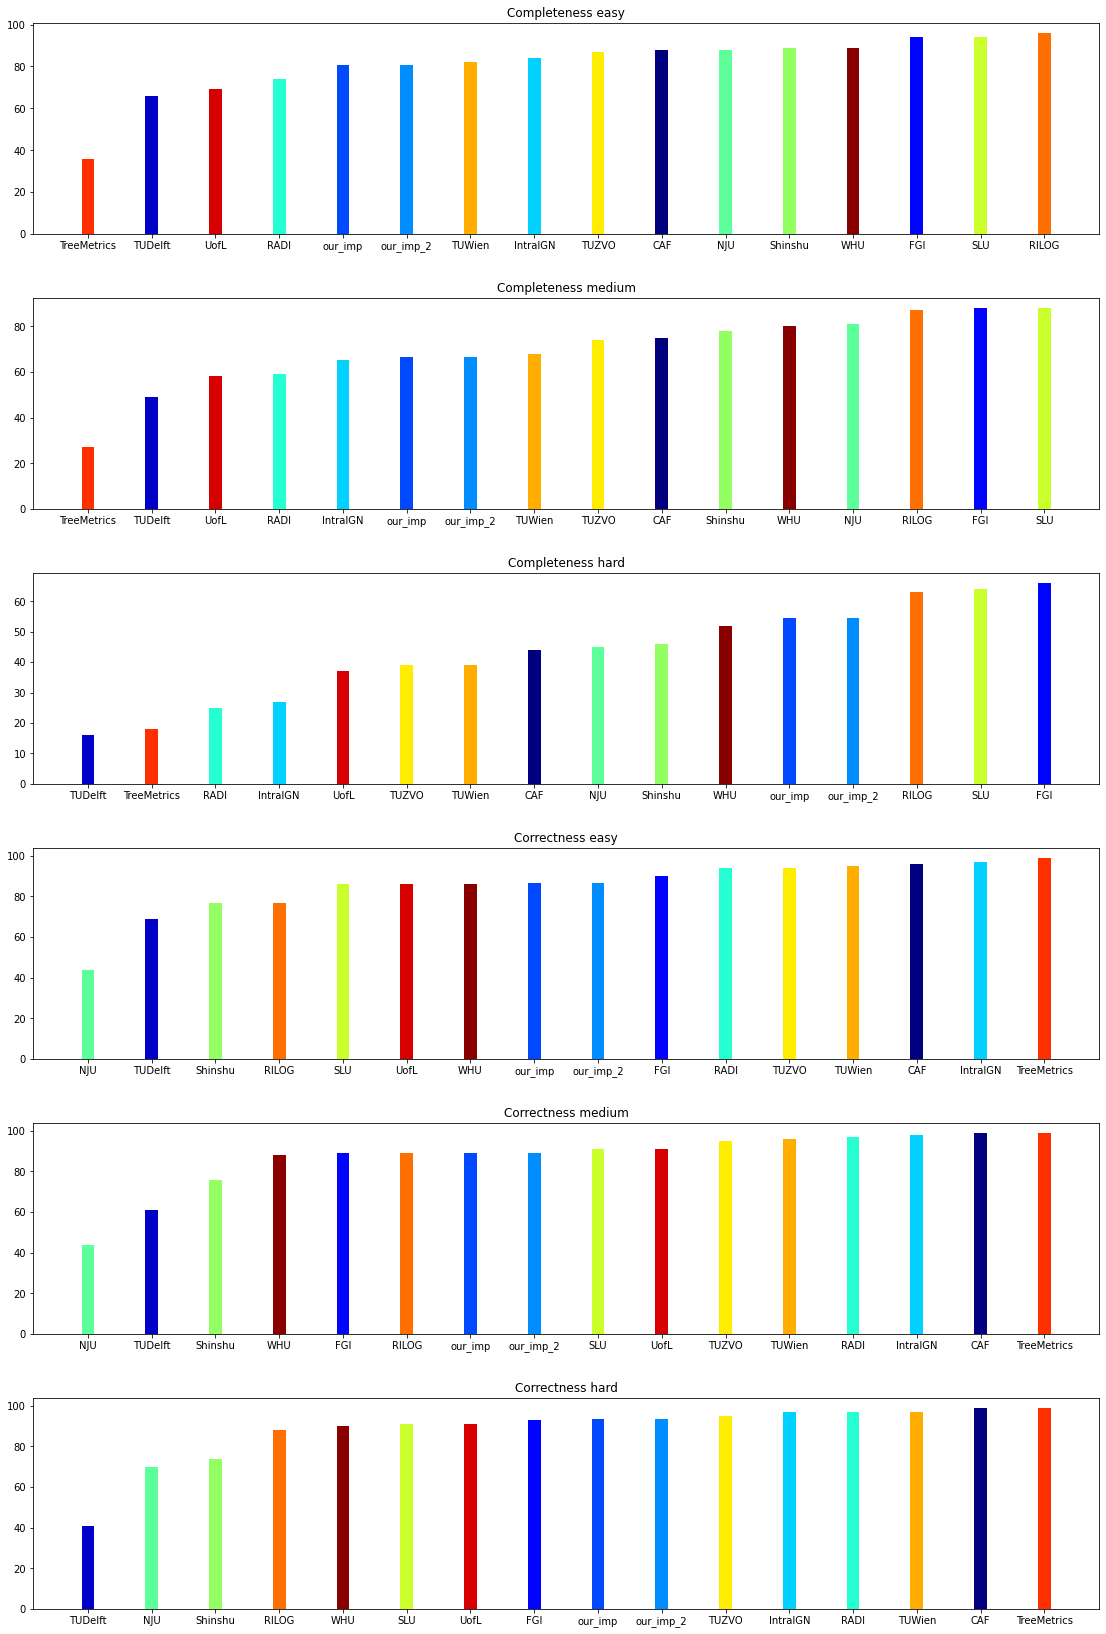

In [108]:
alldata = ['Completeness', 'Correctness']
dificulties = ['easy', 'medium', 'hard']
plt.figure(figsize=(16,46))
for n,i in enumerate(alldata):
    for n2 in range(3):
        plt.subplot(12,1,n*3+n2+1)
        plt.title(i + ' ' + dificulties[n2])
        mine = np.mean(EvaluationMetrics[i][slice(n2,n2+2)])*100
        mine2 = np.mean(EvaluationMetrics2[i][slice(n2,n2+2)])*100
        #colors=['black', 'red', 'green', 'blue', 'cyan', 'magenta', 'yellow','black', 'red', 'green', 'blue', 'cyan', 'magenta', 'yellow']
        sortstuff = sorted(zip(Methods[0:3] + ['our_imp'] + ['our_imp_2'] + Methods[3:],BenchmarkMetrics[i][n2][0:3] + [mine] + [mine2] + BenchmarkMetrics[i][n2][3:],colors),key=lambda x:x[1])
        sortmethods = [i[0] for i in sortstuff]
        sortnum = [i[1] for i in sortstuff]
        sortcol = [i[2] for i in sortstuff]
        #plt.bar(np.arange(len(BenchmarkMetrics[i][n2])+1),BenchmarkMetrics[i][n2]+[mine])
        plt.bar(sortmethods, sortnum
                , color = sortcol, width = 0.2)
        plt.tight_layout(pad=3.0)
        
plt.savefig('metricsnew.png',pad_inches = 0.1, bbox_inches='tight')

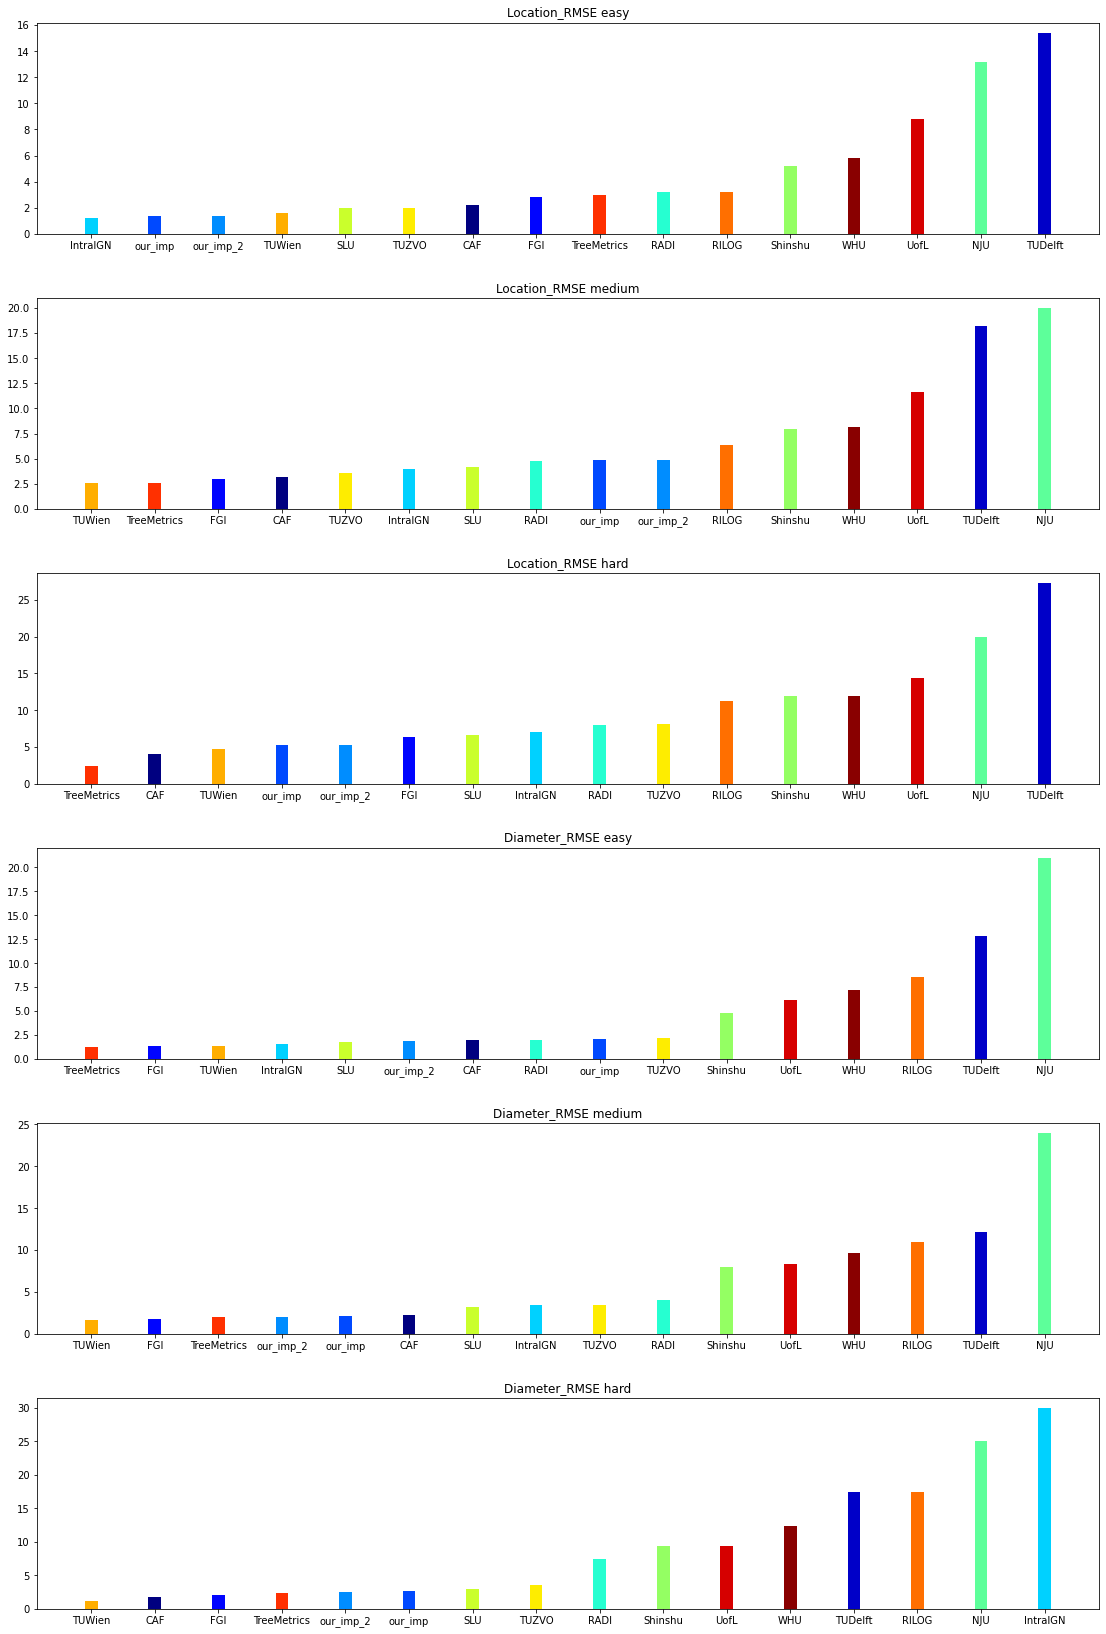

In [109]:
alldata = ['Location_RMSE', 'Diameter_RMSE']
dificulties = ['easy', 'medium', 'hard']
plt.figure(figsize=(16,46))
for n,i in enumerate(alldata):
    for n2 in range(3):
        plt.subplot(12,1,n*3+n2+1)
        plt.title(i + ' ' + dificulties[n2])
        mine = np.mean(EvaluationMetrics[i][slice(n2,n2+2)])*100
        mine2 = np.mean(EvaluationMetrics2[i][slice(n2,n2+2)])*100
        #colors=['black', 'red', 'green', 'blue', 'cyan', 'magenta', 'yellow','black', 'red', 'green', 'blue', 'cyan', 'magenta', 'yellow']
        sortstuff = sorted(zip(Methods[0:3] + ['our_imp'] + ['our_imp_2'] + Methods[3:],BenchmarkMetrics[i][n2][0:3] + [mine] + [mine2] + BenchmarkMetrics[i][n2][3:],colors),key=lambda x:x[1])
        sortmethods = [i[0] for i in sortstuff]
        sortnum = [i[1] for i in sortstuff]
        sortcol = [i[2] for i in sortstuff]
        #plt.bar(np.arange(len(BenchmarkMetrics[i][n2])+1),BenchmarkMetrics[i][n2]+[mine])
        plt.bar(sortmethods, sortnum
                , color = sortcol, width = 0.2)
        plt.tight_layout(pad=3.0)
plt.savefig('metricsnew2.png',pad_inches = 0.1, bbox_inches='tight')